# Ensemble Learning

## Bagging

Bagging(Bootstrap Aggregating)

通過從樣本中進行抽樣，生成多個訓練子集，並在這些子集上訓練多個模型。最後，這些模型的預測結果通過投票或平均的方式進行結合，以提高整體預測性能。
- 訓練過程
    - 從原始訓練數據中進行有放回的抽樣，生成多個訓練子集。
    - `BaggingClassifier` 已有重複抽樣的機制，自動從訓練數據中隨機抽取多個樣本集。
    - 在每個抽樣子集上訓練一個模型，生成多個模型。
    - 對新數據進行預測時，將新數據分別輸入到每個模型中，得到多個預測結果。
    - 如果模型是分類問題，則多個分類器的結果通過投票方式來決定最終結果。
    - 如果模型是回歸問題，則多個回歸器的結果通過計算平均數來決定最終結果。
- 優點
    - 可以有效降低模型對於訓練數據中噪聲的敏感度。
        - 抽樣就有機會不讓有噪聲資料(不好的資料)被訓練到。
        - 可以減少噪聲對模型的影響，提高模型的穩定性。
    - 通過多個模型的結合來進行預測，這可以降低單個模型過擬合的風險。集成方法通常比單一模型更具穩健性和泛化能力。
    - 每個模型之間是相互獨立的，因此可以進行平行計算，提高訓練和預測的效率。
- Common Bagging algorithms: Random forest,
- [Bootstrap aggregating bagging](https://www.youtube.com/watch?v=2Mg8QD0F1dQ)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# data prep
train_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

def get_nulls(train, test):
    print("Training Data:")
    print(pd.isnull(train).sum())
    print("Testing Data:")
    print(pd.isnull(test).sum())
train_data.fillna({"Age": train_data["Age"].median(), "Embarked": "S"}, inplace=True)
test_data.fillna({"Age": test_data["Age"].median(), "Fare": test_data["Fare"].median()}, inplace=True)

# Standardization 
encoder_1 = LabelEncoder()
encoder_1.fit(train_data["Sex"])
train_data["Sex"] = encoder_1.transform(train_data["Sex"])
test_data["Sex"] = encoder_1.transform(test_data["Sex"])

encoder_2 = LabelEncoder()
encoder_2.fit(train_data["Embarked"])
train_data["Embarked"] = encoder_2.transform(train_data["Embarked"])
test_data["Embarked"] = encoder_2.transform(test_data["Embarked"])

scaler = StandardScaler()
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
test_data[['Age', 'Fare']] = scaler.transform(test_data[['Age', 'Fare']])

X_features = train_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = train_data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

# Bagging Classification Example
def bagging_ensemble(model, model_name):
    k_folds = KFold(n_splits=20, random_state=12, shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=k_folds)
    print(f"{model_name} Accuracy: {results.mean():.4f}")
    return results.mean()

# Initialize each model
LogReg_clf = LogisticRegression()
DTree_clf = DecisionTreeClassifier()
SVC_clf = SVC()

logreg_bagging_model = BaggingClassifier(estimator=LogReg_clf, n_estimators=50, random_state=42)
dtree_bagging_model = BaggingClassifier(estimator=DTree_clf, n_estimators=50, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
extra_tree_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Execute Bagging integration method
logreg_score = bagging_ensemble(logreg_bagging_model, "Logistic Regression")
dtree_score = bagging_ensemble(dtree_bagging_model, "Decision Tree")
rf_score = bagging_ensemble(rf_model, "Random Forest")
extra_tree_score = bagging_ensemble(extra_tree_model, "Extra Trees")

Logistic Regression Accuracy: 0.7940
Decision Tree Accuracy: 0.8101
Random Forest Accuracy: 0.8201
Extra Trees Accuracy: 0.7951


## Boosting

Boosting
- 是一種通過結合多個弱分類器形成一個強分類器來提高整體模型性能的方法。
- 過程
    - 初始模型：從一個簡單的模型開始（例如，一個決策樹）。
    - 誤差計算：計算初始模型的誤差（即模型預測結果與實際結果之間的差異）。
    - 加權：增加誤差較大的樣本的權重，使得下一個模型在訓練時更加關注這些錯誤預測的樣本。
    - 新模型：訓練一個新的模型，專注於修正上一步模型中的錯誤。
    - 重複：反復進行上述步驟，將新的模型不斷加入到現有模型中。
- Common Boosting algorithms: AdaBoost, XGBoost, ...
- [Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw)

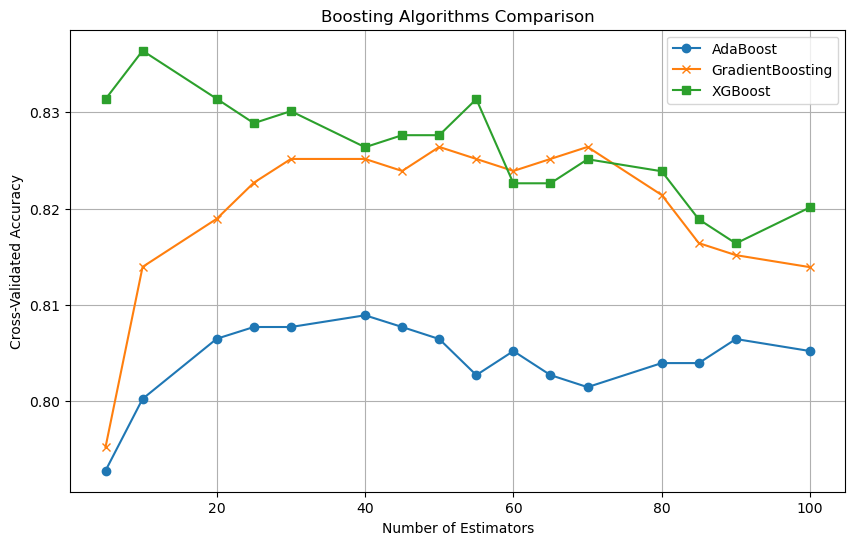

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

# load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# data prep
train_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test_data.drop(labels=['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

def get_nulls(train, test):
    print("Training Data:")
    print(pd.isnull(train).sum())
    print("Testing Data:")
    print(pd.isnull(test).sum())
train_data.fillna({"Age": train_data["Age"].median(), "Embarked": "S"}, inplace=True)
test_data.fillna({"Age": test_data["Age"].median(), "Fare": test_data["Fare"].median()}, inplace=True)

# Standardization 
encoder_1 = LabelEncoder()
encoder_1.fit(train_data["Sex"])
train_data["Sex"] = encoder_1.transform(train_data["Sex"])
test_data["Sex"] = encoder_1.transform(test_data["Sex"])

encoder_2 = LabelEncoder()
encoder_2.fit(train_data["Embarked"])
train_data["Embarked"] = encoder_2.transform(train_data["Embarked"])
test_data["Embarked"] = encoder_2.transform(test_data["Embarked"])

scaler = StandardScaler()
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
test_data[['Age', 'Fare']] = scaler.transform(test_data[['Age', 'Fare']])

X_features = train_data.drop(labels=['PassengerId', 'Survived'], axis=1)
y_labels = train_data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X_features, y_labels, test_size=0.1,random_state=12)

# Example Boosting Classification
k_folds = KFold(n_splits=20, random_state=12, shuffle=True)
num_estimators = [5, 10, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 80, 85, 90, 100]

ada_results = []
gb_results = []
xgb_results = []

# Evaluate AdaBoost
for i in num_estimators:
    ada_boost = AdaBoostClassifier(n_estimators=i, random_state=12, algorithm='SAMME')
    results = cross_val_score(ada_boost, X_train, y_train, cv=k_folds)
    ada_results.append(results.mean())

# Evaluate GradientBoosting
for i in num_estimators:
    grad_boost = GradientBoostingClassifier(n_estimators=i, random_state=12)
    results = cross_val_score(grad_boost, X_train, y_train, cv=k_folds)
    gb_results.append(results.mean())

# Evaluate XGBoost
for i in num_estimators:
    xgb_boost = xgb.XGBClassifier(n_estimators=i, random_state=12)
    results = cross_val_score(xgb_boost, X_train, y_train, cv=k_folds)
    xgb_results.append(results.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_estimators, ada_results, label='AdaBoost', marker='o')
plt.plot(num_estimators, gb_results, label='GradientBoosting', marker='x')
plt.plot(num_estimators, xgb_results, label='XGBoost', marker='s')
plt.title('Boosting Algorithms Comparison')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid(True)
plt.show()

參考資料:

[Hung-yi Lee - ML Lecture 22: Ensemble](https://www.youtube.com/watch?v=tH9FH1DH5n0)